# 6.1 Классификация.Соискатели

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Отправьте результат нам

### Полезная литература

- [ODS - классификация](https://habrahabr.ru/company/ods/blog/322534/)
- [Коллаборативная фильтрация - рекомендательная система](https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D0%BB%D0%BB%D0%B0%D0%B1%D0%BE%D1%80%D0%B0%D1%82%D0%B8%D0%B2%D0%BD%D0%B0%D1%8F_%D1%84%D0%B8%D0%BB%D1%8C%D1%82%D1%80%D0%B0%D1%86%D0%B8%D1%8F)
- [Метрики расстояний - косинусная, минковского, проклятье размерности ](http://www.machinelearning.ru/wiki/images/9/9a/Sem1_knn.pdf)
- [Offtop: метрики качества рекомендаьельных систем](https://habrahabr.ru/company/dca/blog/281066/)

## kNN - ближайшие соседи (15 баллов)

Рассмотрим задачу из соревнования [Amazon Employee Access Challenge](https://www.kaggle.com/c/amazon-employee-access-challenge).

В данной задаче предлагается предсказать, будет ли одобрен запрос сотрудника на получение доступа к тому или иному ресурсу. Все признаки являются категориальными.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import scale

In [2]:
df = pd.read_csv('../../data/amazon.csv.gz')
df.head()
# ACTION - это целевой признак

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


Обратим внимание, что выборка не сбалансированная. В качестве метрики качества будем использовть [f1-score](https://en.wikipedia.org/wiki/F1_score). 
$$F_1 = 2 \cdot \frac{\mathrm{precision} \cdot \mathrm{recall}}{\mathrm{precision} + \mathrm{recall}}$$

$$precision = \frac{TP}{TP+FP}$$

$$recall = \frac{TP}{TP+FN}$$

0.9421099209618847


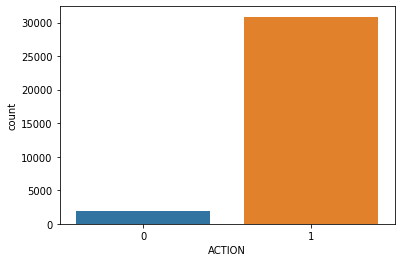

In [3]:
print(df['ACTION'].mean())
sns.countplot('ACTION', data=df)

In [4]:
# число значений у признаков
for col_name in df.columns:
    print(col_name, len(df[col_name].unique()))

ACTION 2
RESOURCE 7518
MGR_ID 4243
ROLE_ROLLUP_1 128
ROLE_ROLLUP_2 177
ROLE_DEPTNAME 449
ROLE_TITLE 343
ROLE_FAMILY_DESC 2358
ROLE_FAMILY 67
ROLE_CODE 343


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32769 entries, 0 to 32768
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   ACTION            32769 non-null  int64
 1   RESOURCE          32769 non-null  int64
 2   MGR_ID            32769 non-null  int64
 3   ROLE_ROLLUP_1     32769 non-null  int64
 4   ROLE_ROLLUP_2     32769 non-null  int64
 5   ROLE_DEPTNAME     32769 non-null  int64
 6   ROLE_TITLE        32769 non-null  int64
 7   ROLE_FAMILY_DESC  32769 non-null  int64
 8   ROLE_FAMILY       32769 non-null  int64
 9   ROLE_CODE         32769 non-null  int64
dtypes: int64(10)
memory usage: 2.5 MB


# Baseline (4 балла)

Сразу проверим как ведет себя kNN на неподготовленных данных и без тюнинга. Зафиксируйте `n_neighbors=5`, `p=2`. 

- создайте экземпляр `KNeighborsClassifier` с указанными параметрами, обучите его методом `fit` и предскажите значения `predict` для треничровчных данных `X_test`.
- постройте отчет классификации (classification_report)
- постройте confusion matrix и нарисуйте heatmap

Обратите внимание на confusion matrix. Какой вывод вы можете сделать из неё? Вспомните лекцию и значение ошибок 1 и 2 рода.

In [6]:
X= df.drop(['ACTION'],axis=1)
y= df['ACTION']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.33)

In [8]:
clf = KNeighborsClassifier(n_neighbors=5, p=2)
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [9]:
y_pred = clf.predict(X_test).astype('int')

In [12]:
#отчет классификации
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.34      0.09      0.14       614
           1       0.95      0.99      0.97     10200

    accuracy                           0.94     10814
   macro avg       0.64      0.54      0.55     10814
weighted avg       0.91      0.94      0.92     10814



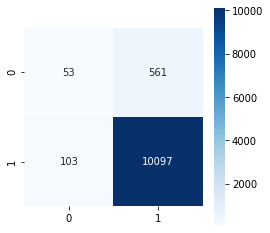

In [16]:
plt.figure(figsize=(4,4)) 
_ = sns.heatmap(confusion_matrix(y_test, y_pred), cmap=plt.cm.Blues, square=True, annot=True, fmt='.5g')

Выводы:
- плотность 0 очень низкая, всего 9% предсказано верно, да и precision не высока, соответственно f1 тоже низкая. Т.к. классы не сбалансированны, то данных для 0 мало, так же мало и фич, которые помогают отнести к этому классу.
- общая accuracy высокая, но она ничего не значит, когда классы имеют такой большой дизбаланс, по сути модель в более чем 90% дает доступ пользователю, это было бы и не плохо, если бы macro avg не была такой низкой.

При фиксированном `n_neighbors=10` проверьте значение метрики на кроссвалидации на 5-фолдах для разных значений `p` из `(1,2,4,6)`. При каком значение `p` метрика достигает максимума?

При кроссвалидации у вас будет получаться N разных значений метрики. Выводите среднее значение и стандартное отклонение.

In [17]:
from sklearn.model_selection import GridSearchCV

In [19]:
params = {
            "n_neighbors": [10], 
            "p": [1,2,4,6]
         }

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = GridSearchCV(KNeighborsClassifier(), params, cv=cv, verbose=2,n_jobs=-1)                    

%time search.fit(X, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


CPU times: user 231 ms, sys: 61.6 ms, total: 292 ms
Wall time: 24.9 s


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   24.8s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_neighbors': [10], 'p': [1, 2, 4, 6]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [20]:
print("BEST: score={}, params={}".format(search.best_score_, search.best_params_))

BEST: score=0.9403399785072131, params={'n_neighbors': 10, 'p': 4}


BEST: score=0.9403399785072131, params={'n_neighbors': 10, 'p': 4}


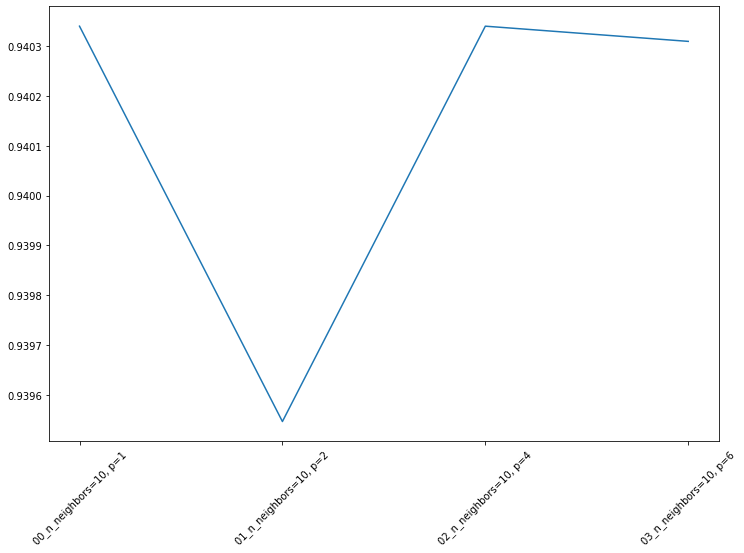

In [17]:
x_ticks = ["{:02d}_n_neighbors={}, p={}".format(i, p['n_neighbors'], p['p']) for i,p in enumerate(search.cv_results_['params'])]

plt.figure(figsize=(12,8))
plt.plot(x_ticks, search.cv_results_['mean_test_score'])
_ =plt.xticks(rotation=45)

print("BEST: score={}, params={}".format(search.best_score_, search.best_params_))

Отчет классификации стал еще хуже:

              precision    recall  f1-score   support

           0       0.25      0.03      0.05       614
           1       0.94      0.99      0.97     10200

    accuracy                           0.94     10814
   macro avg       0.60      0.51      0.51     10814
weighted avg       0.91      0.94      0.92     10814



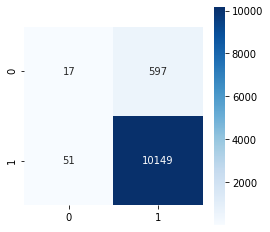

In [21]:
clf = KNeighborsClassifier(n_neighbors=search.best_params_['n_neighbors'], p=search.best_params_['p'])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test).astype('int')

print(classification_report(y_test, y_pred))

plt.figure(figsize=(4,4))
_ = sns.heatmap(confusion_matrix(y_test, y_pred), cmap=plt.cm.Blues, square=True, annot=True, fmt='.5g')

# Счетчики (6 баллов)

Очевидно, что предсказывать лейбл объекта, используя при этом метрический алгоритм на категориальных признаках - это ОЧЕНЬ странная затея. Не удивительно что качество ужасное. Необходимо каким-то образом заменить категориальные признаки вещественными:

- OneHotEncoding - это когда для каждого признака создают другие N бинарных признаков, где N - это количество категорий у категориального признака.
- Счетчики - об это написано в статье http://blogs.technet.com/b/machinelearning/archive/2015/02/17/big-learning-made-easy-with-counts.aspx.
- Еще https://docs.microsoft.com/en-us/azure/machine-learning/studio-module-reference/data-transformation-learning-with-counts
-  Практический пример https://turi.com/learn/userguide/feature-engineering/count_featurizer.html
- Другие варианты энкодинга + счетчики https://kiwidamien.github.io/encoding-categorical-variables.html

Мы реализуем алгоритм Счетчиков. Его нет в sklearn, поэтому придется реализовать самому. 

Для каждого категориального признака создайте 3 других признака:
1. Число `counts` объектов в обучающей выборке с таким же значением признака.
2. Число `successes` объектов первого класса ($y = 1$) в обучающей выборке с таким же значением признака.
3. Сглаженное отношение двух предыдущих величин: (`successes` + 1) / (`counts` + 2).

Поскольку признаки, содержащие информацию о целевой переменной, могут привести к переобучению, может оказаться полезным сделать *фолдинг*: разбить обучающую выборку на $n$ частей, и для $i$-й части считать `counts` и `successes` по всем остальным частям. Для тестовой выборки используются счетчики, посчитанные по всей обучающей выборке. Реализуйте и такой вариант. Можно использовать $n = 3$.

Обучение надо проводить только по новым признакам. Изначальные мы не используем.

Подсказка - вам нужно для каждой колонки посчитать 2 аггрегации - сумму и количество. Для замены конкретного значения посчитанным используйте функцию apply над датафреймом. Простое решение займет около 10 строк кода.

![](http://images6.fanpop.com/image/photos/38600000/taiga-iamyourenemy-38620719-282-160.gif)

!!! [Тут](https://kiwidamien.github.io/encoding-categorical-variables.html) указаны следующие параметры создания счетчиков. Что имеется ввиду под is_leftover?

The DRACuLa encoder isn't supported yet by category encoders. It is an interesting exercise to "roll your own". It is generally for classification problems. We are going to introduce the concept of "buckets": the most frequently occurring B levels get their own buckets. All other levels share the leftover bucket.

For binary classification, DRACuLa produces 4 columns:

    N+: the number of times the positive class has been seen in this bucket,
    N-: the number of times the negative class has been seen in this bucket,
    log(N+/N-): the log likelihood,
    is_leftover: boolean, indicating if this was one of the B levels that got its own bucket (False), or if we were in the "leftover" bucket (True)


![](https://turi.com/learn/userguide/feature-engineering/images/count_featurizer_data_split.png)

In [19]:
#df5 = df.iloc[41:56]
#df5

In [20]:
#XX= df5.drop(['ACTION'],axis=1)
#yy= df5['ACTION']

In [21]:
#X_train, X_test, y_train, y_test = train_test_split(XX, yy, random_state=42, test_size=0.3, stratify=yy)

In [22]:
#X_train

In [23]:
#X_train_split = int(X_train.shape[0]*0.7)
#X_train_split

In [24]:
#X_train.iloc[:X_train_split]

In [25]:
#X_train.iloc[X_train_split:]

###### Равномерное разбиение по группам

Чтобы избежать переобучения, тестовая выборка будет разбита на 2 части, для одной из которых будут подсчитаны counters, а другая будет просто брать эти значения. Но, если разбить данные "в лоб", то после подсчета счетчиков, может оказаться, то во второй части выборки будут группы, которые не попали в первую часть и соответственно для них не были подсчитаны счетчики. Постараюсь этого избежать, разбив тестовую выборку более-менее равномерно по всем категориальным фичам.

Инструмент разбиения всех данных равномерно model selection group shufle split  
https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py

Какое соотношение по категориальным фичам в исходном датасете?

In [40]:
X = df.drop(['ACTION'],axis=1)
y = df['ACTION']

In [182]:
def index_unique(df, df_split, min_count_uniq=0):
    '''
    Коэффициент полноты уникальных значений.
    Показывает на сколько в текущих данных присутствует все значения категорий. 1 - 100%
    '''
    def count_unique(df,min_count_uniq=0):
        #Возвращает df с уникальными значениями и их количеством
        grp_cnt =df.groupby([col])[col].count()
        df_fc = pd.DataFrame(dict(value=grp_cnt.index, count=grp_cnt.values))
        df_fc = df_fc[df_fc['count']>min_count_uniq]
        return df_fc
    
    df_iu=pd.DataFrame()
    for col in df.columns:  
        uniq_count = count_unique(df.copy(),min_count_uniq).shape[0]
        split_uniq_count = count_unique(df_split.copy(),min_count_uniq).shape[0]
        if (0==split_uniq_count or 0==uniq_count):
            index_unique=0
        else:
            index_unique = split_uniq_count/uniq_count
        values = [index_unique, '{}/{}'.format(split_uniq_count,uniq_count)]
        df_iu.at[0, col] = '{0:.2f}'.format(index_unique)
        df_iu.at[1, col] = '{}/{}'.format(uniq_count,split_uniq_count)
        df_iu.at[2, col] = '{}'.format(uniq_count)
    return df_iu

In [222]:
#На исходных ндекс должен равняться 1
index_unique(X.copy(),X.copy(),0)

,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
1,7518/7518,4243/4243,128/128,177/177,449/449,343/343,2358/2358,67/67,343/343
2,7518,4243,128,177,449,343,2358,67,343


Какое соотношение по группам при стандартном разбиении?

In [173]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3, stratify=y)

In [184]:
index_unique(X.copy(),X_train.copy(),0)

,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,0.83,0.92,0.96,0.95,0.98,0.95,0.89,0.97,0.95
1,7518/6238,4243/3898,128/123,177/169,449/438,343/327,2358/2109,67/65,343/327
2,7518,4243,128,177,449,343,2358,67,343


In [190]:
#средний коэффициент содержания всех уникальных значений исходной выборки в разделенной
index_unique(X.copy(),X_train.copy(),0).loc[0].astype('float').mean()

0.9333333333333333

In [320]:
index_unique(X.copy(),X_train_orig.copy(),0)

,k1,k1_count,k1_successes,k1_flattened
0,1.00,0.00,0.00,0.00
1,3/3,0/2,0/3,0/3
2,3,0,0,0


In [23]:
def CountAndSuccCalc(df, df_counts, col_name, method=1):
    '''
    Подсчет новых признаков - счетчиков
    '''
      
    if (1==method): #Метод из задания
        c = df[col_name].apply(lambda value: df_counts[value].sum()) #сумма встречающихся значений 0 и 1, по сути количество категории
        s = df[col_name].apply(lambda value: df_counts[value].iloc[1]) #количество значения категории при у=1
        f = (s+1)/(c+2)
        out = [c,s,f]
    if (2==method): #Метод из интернета
        c = df[col_name].apply(lambda value: df_counts[value].sum()) #сумма встречающихся значений 0 и 1, по сути количество категории
        s = df[col_name].apply(lambda value: df_counts[value].iloc[1]) #количество значения категории при у=1
        n = c-s #количество значения категории при у=0
        f = np.log((s+1)/(n+1)) 
        #??? По умолчанию все элементы с количеством меньше 10 собираются в одном контейнере, называемом «мусорное ведро».
        out = [c,s,n,f]
        
    return out

In [27]:
def CountAndSuccMain (df, train_part_by_target_size=0.7, y_name = 'ACTION', method=1):
    '''
    Формирование новых признаков - счетчиков.
    Тренеровочная выборка будет разбита на 2 части, для первой будут подсчитаны счетчики, воторая часть будет 
    брать уже готовые счетчики первой части.
    
    train_part_by_target_size - пропорция от общего числа тренеровочной выборки, у которой counts и successes будут 
                    строится по целевому признаку, остальные части на основании train_part_by_target_size.
                    Если == 1, то вторая часть тренеровочной выборки буде считаться тоже по целевому признаку
    '''
    
    #Создаю новые признаки и наполняю их NaN, далее буду считать точные значения
    col_names = df.columns
    for col_name in col_names:
        if col_name == y_name: #пропускаю target
            continue
        if (1==method):
            df[col_name+'_count'], df[col_name+'_successes'], df[col_name+'_flattened'] = list(3*[np.NaN])
        if (2==method):
            df[col_name+'_count'], df[col_name+'_successes'], df[col_name+'_not_successes'], df[col_name+'_flattened'] = list(4*[np.NaN])
 
    X = df.drop([y_name],axis=1)
    y = df[y_name]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3, stratify=y)
    
    X_train_spliter = int(X_train.shape[0]*train_part_by_target_size)# Индекс-разделитель тренеровочной выборки на 2 части
    X_train_by_target = X_train.iloc[:X_train_spliter] # Новые признаки-счетчики для этой части будут строиться на основе целевого
    X_train = X_train.iloc[X_train_spliter:] # Новые признаки-счетчики для этой части будут строиться на основе X_train_by_target
       
    #Счетчики для первой части тренеровочной выборки
    for col_name in col_names:
        if col_name == y_name:
            continue
                    #формирую новую выборку с целевой переменной,на основе индексов train_test_split, чтобы произвести рассчеты    
        df_counts = pd.DataFrame(index=X_train_by_target.index, data=df).groupby([y_name,col_name])[col_name].count().unstack().fillna(0)# группирую данные в таблицу, где именования столбцов это уникальные значения col_name, а в строках количество повторений при у = [0,1] 
        if (1==method):
            X_train_by_target[col_name+'_count'], X_train_by_target[col_name+'_successes'], X_train_by_target[col_name+'_flattened'] = CountAndSuccCalc(X_train_by_target,df_counts,col_name)  
        if (2==method):
            X_train_by_target[col_name+'_count'], X_train_by_target[col_name+'_successes'], X_train_by_target[col_name+'_not_successes'], X_train_by_target[col_name+'_flattened'] = CountAndSuccCalc(X_train_by_target,df_counts,col_name, 2)  
  
    #Счетчики на основе первой части тренеровочной выборки
    for col_name in col_names:
        if col_name == y_name:
            continue
        
        if X_train.shape[0] > 0: #Если есть втроая часть тренеровочной выборки (train_part_by_target_size<1)
            for value in X_train[col_name].unique():#Счетчики для второй части тренеровочной выборки на основе первой части     
                if value in X_train_by_target[col_name].values: # Если в первой части тренеровочной выборки существует значение из второй части тренеровочной выборки
                    if (1==method):
                        X_train.loc[X_train[col_name] == value,[col_name+'_count',col_name+'_successes',col_name+'_flattened']] = X_train_by_target.loc[X_train_by_target[col_name] == value,[col_name+'_count',col_name+'_successes',col_name+'_flattened']][:1].values[0]                
                    if (2==method):
                        X_train.loc[X_train[col_name] == value,[col_name+'_count',col_name+'_successes',col_name+'_not_successes',col_name+'_flattened']] = X_train_by_target.loc[X_train_by_target[col_name] == value,[col_name+'_count',col_name+'_successes',col_name+'_not_successes',col_name+'_flattened']][:1].values[0]                
        
        for value in X_test[col_name].unique(): #Счетчики для тестовой выборки на основе первой части тренеровочной выборки
            if value in X_train_by_target[col_name].values: # Если в первой части тренеровочной выборки существует значение из тестовой выборки
                if (1==method):
                    X_test.loc[X_test[col_name] == value,[col_name+'_count',col_name+'_successes',col_name+'_flattened']] = X_train_by_target.loc[X_train_by_target[col_name] == value,[col_name+'_count',col_name+'_successes',col_name+'_flattened']][:1].values[0]                
                if (2==method):
                    X_test.loc[X_test[col_name] == value,[col_name+'_count',col_name+'_successes',col_name+'_not_successes',col_name+'_flattened']] = X_train_by_target.loc[X_train_by_target[col_name] == value,[col_name+'_count',col_name+'_successes',col_name+'_not_successes',col_name+'_flattened']][:1].values[0]                

    
    #print('------------ train_part_one:\n\n{}'.format(X_train_by_target))
    #print('\n------------ train_part_two:\n\n{}'.format(X_train))
    #print('\n------------ test:\n\n{}'.format(X_test))
    X_train = pd.concat([X_train_by_target,X_train])
    return X_train[np.setdiff1d(X_train.columns,col_names)], X_test[np.setdiff1d(X_test.columns,col_names)], y_train, y_test

In [339]:
y_name = 'ACTION'
col_name = 'RESOURCE'

X = df.drop([y_name],axis=1)
y = df[y_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3, stratify=y) 
X_train[col_name]

np.bincount(X_train[col_name])
#X_col_train, X_col_train2, y_col_train, y_col_train2 = train_test_split(X_train, y_train, random_state=42, test_size=0.2, stratify=X_train[col_name])


array([11,  0,  0, ...,  0,  1,  1])

In [345]:
X_train[[col_name]].groupby(col_name)[col_name].count()

RESOURCE
0         11
38         4
136        1
138        2
153       10
          ..
312136     1
312139     1
312140     1
312152     1
312153     1
Name: RESOURCE, Length: 6238, dtype: int64

In [324]:
def CountAndSuccMain2 (df, train_part_by_target_size=0.7, y_name = 'ACTION', method=1):
    '''
    Формирование новых признаков - счетчиков.
    Тренеровочная выборка будет разбита на 2 части, для первой будут подсчитаны счетчики, воторая часть будет 
    брать уже готовые счетчики первой части.
    
    train_part_by_target_size - пропорция от общего числа тренеровочной выборки, у которой counts и successes будут 
                    строится по целевому признаку, остальные части на основании train_part_by_target_size.
                    Если == 1, то вторая часть тренеровочной выборки буде считаться тоже по целевому признаку
    '''
    
    #Создаю новые признаки и наполняю их NaN, далее буду считать точные значения
    col_names = df.columns
    for col_name in col_names:
        if col_name == y_name: #пропускаю target
            continue
        if (1==method):
            df[col_name+'_count'], df[col_name+'_successes'], df[col_name+'_flattened'] = list(3*[np.NaN])
        if (2==method):
            df[col_name+'_count'], df[col_name+'_successes'], df[col_name+'_not_successes'], df[col_name+'_flattened'] = list(4*[np.NaN])
 
    X = df.drop([y_name],axis=1)
    y = df[y_name]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3, stratify=y)    
    X_train_new = pd.DataFrame()
    
    #Тренеровочную выборку еще разобью на 2 части, для одной подсчитаю counters, для другой возьму значения на основе первой
    for col_name in col_names:
        if col_name == y_name: #пропускаю target
            continue
        #Беру новую выборку равномерно разбитую(stratify) по уникальным значениям категории col_name
        print(col_name)
        if (train_part_by_target_size <1):
            X_col_train, X_col_train2, y_col_train, y_col_train2 = train_test_split(X_train, y_train, random_state=42, test_size=1-train_part_by_target_size, stratify=X_train[col_name])
        else:
            X_col_train, X_col_train2, y_col_train, y_col_train2 = X_train, pd.DataFrame(), y_train, pd.DataFrame()

    ###Счетчики для первой части тренеровочной выборки 
        X_train_by_target = pd.concat([X_col_train, y_col_train], axis=1, sort=False)
        
        df_counts = X_train_by_target.groupby([y_name,col_name])[col_name].count().unstack().fillna(0)# группирую данные в таблицу, где именования столбцов это уникальные значения col_name, а в строках количество повторений при у = [0,1] 
        if (1==method):
            X_train_by_target[col_name+'_count'], X_train_by_target[col_name+'_successes'], X_train_by_target[col_name+'_flattened'] = CountAndSuccCalc(X_train_by_target,df_counts,col_name)  
        if (2==method):
            X_train_by_target[col_name+'_count'], X_train_by_target[col_name+'_successes'], X_train_by_target[col_name+'_not_successes'], X_train_by_target[col_name+'_flattened'] = CountAndSuccCalc(X_train_by_target,df_counts,col_name, 2)  
        print(X_train_by_target)
    ###Счетчики для второй части на основе первой части тренеровочной выборки
        if X_col_train2.shape[0] > 1: #Если есть втроая часть тренеровочной выборки (train_part_by_target_size<1)          
            for value in X_col_train2[col_name].unique():#Счетчики для второй части тренеровочной выборки на основе первой части     
                if value in X_train_by_target[col_name].values: # Если в первой части тренеровочной выборки существует значение из второй части тренеровочной выборки
                    if (1==method):
                        X_col_train2.loc[X_col_train2[col_name] == value,[col_name+'_count',col_name+'_successes',col_name+'_flattened']] = X_train_by_target.loc[X_train_by_target[col_name] == value,[col_name+'_count',col_name+'_successes',col_name+'_flattened']][:1].values[0]                
                    if (2==method):
                        X_col_train2.loc[X_col_train2[col_name] == value,[col_name+'_count',col_name+'_successes',col_name+'_not_successes',col_name+'_flattened']] = X_train_by_target.loc[X_train_by_target[col_name] == value,[col_name+'_count',col_name+'_successes',col_name+'_not_successes',col_name+'_flattened']][:1].values[0]                
        #Объединяю 2 части тренеровочной выборки в единую       
        X_train_new = pd.concat([X_train_new,pd.concat([X_train_by_target,X_col_train2])])
    
    ###Счетчики для тестовой выборки на основе тренеровочной выборки
        for value in X_test[col_name].unique(): #Счетчики для тестовой выборки на основе первой части тренеровочной выборки
            if value in X_train_by_target[col_name].values: # Если в первой части тренеровочной выборки существует значение из тестовой выборки
                if (1==method):
                    X_test.loc[X_test[col_name] == value,[col_name+'_count',col_name+'_successes',col_name+'_flattened']] = X_train_by_target.loc[X_train_by_target[col_name] == value,[col_name+'_count',col_name+'_successes',col_name+'_flattened']][:1].values[0]                
                if (2==method):
                    X_test.loc[X_test[col_name] == value,[col_name+'_count',col_name+'_successes',col_name+'_not_successes',col_name+'_flattened']] = X_train_by_target.loc[X_train_by_target[col_name] == value,[col_name+'_count',col_name+'_successes',col_name+'_not_successes',col_name+'_flattened']][:1].values[0]                

    
    #return X_train_new[np.setdiff1d(X_train.columns,col_names)], X_test[np.setdiff1d(X_test.columns,col_names)], y_train, y_test
    return X_train_new,X_test,y_train, y_test

In [325]:
X_train_orig, X_test_orig, y_train, y_test = CountAndSuccMain2(df.copy(), 0.7, method=1)

RESOURCE


ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [319]:
X_train_orig

,k1,k1_count,k1_successes,k1_flattened,ACTION
7,2,2.0,0.0,0.250000,0.0
1,1,2.0,2.0,0.750000,1.0
0,1,2.0,2.0,0.750000,1.0
5,2,2.0,0.0,0.250000,0.0
9,3,1.0,1.0,0.666667,1.0
4,2,2.0,0.0,0.250000,NaN
3,1,2.0,2.0,0.750000,NaN
11,3,1.0,1.0,0.666667,NaN


In [308]:
X_test_orig

,k1,k1_count,k1_successes,k1_flattened
6,2,2.0,0.0,0.250000
8,3,1.0,1.0,0.666667
10,3,1.0,1.0,0.666667
2,1,2.0,2.0,0.750000


In [305]:
df_tmp1=pd.DataFrame({'k1':[1,1,1,1,2,2,2,2,3,3,3,3],'ACTION':[1,1,1,1,0,0,0,0,1,1,1,1]})
df_tmp1

,k1,ACTION
0,1,1
1,1,1
2,1,1
3,1,1
4,2,0
5,2,0
6,2,0
7,2,0
8,3,1
9,3,1


In [28]:
#df5 = df.iloc[41:56][['ACTION','ROLE_FAMILY','ROLE_ROLLUP_2','ROLE_DEPTNAME']]
#df5

In [29]:
#X_train, X_test, y_train, y_test = CountAndSuccMain(df5.copy(),1)

In [30]:
#X_train.isnull().sum()

In [31]:
#X_test.isnull().sum()

In [32]:
#X_test

In [33]:
#X_train = X_train.fillna(0)
#X_test = X_test.fillna(0)
#pass

In [34]:
#X_test[:1].info()

In [35]:
#X_test.apply(lambda row: fillna_rowvalue(row), axis=1)

In [ ]:
#df = pd.read_csv('../../data/amazon.csv.gz')

In [35]:
X_train_orig, X_test_orig, y_train, y_test = CountAndSuccMain(df.copy(), 0.7, method=2)

In [52]:
X_train_orig.isnull().sum().sum()

8092

In [53]:
X_test_orig.isnull().sum().sum()

12096

In [83]:
X_train = X_train_orig.apply(lambda x: x.fillna(np.mean(x)))
X_test = X_test_orig.apply(lambda x: x.fillna(np.mean(x)))

In [39]:
X_train.isnull().sum().sum()

0

In [40]:
X_test.isnull().sum().sum()

0

In [148]:
def fillna_rowvalue(r, divider=2):
    r_out=r
    cols_pref = ['_count','_flattened','_successes']
    cols_counts = []
    for col_pref in cols_pref:
        r_short = r[[col for col in r.columns if col_pref in col]]
        #cols_counts.append(np.sum(r_short)/divider)
        new_val = np.sum(r_short)/divider
        r[[col for col in r.columns if col_pref in col]].fillna(new_val)       
    #r_out=r.apply(lambda c: set_newvalues(c)) #Если имя колонки содержет, то такое то значение
    return r_out

In [167]:
col_pref = '_count'
np.sum(X_test[[col for col in X_test.columns if col_pref in col]])/2

MGR_ID_count         0.0
RESOURCE_count      21.0
ROLE_CODE_count    934.0
dtype: float64

In [ ]:
Нужно получить среднее значение по строкам колонок с одинаковым префиксом

In [164]:
divider=2
cols_pref = ['_count','_flattened','_successes']
for col_pref in cols_pref:
    cols=[[col for col in X_test.columns if col_pref in col]]
    #new_value = 
    np.sum(X_test[cols])/divider
    #X_test[cols] = X_test[cols].apply(lambda row: row.fillna(new_value), axis=1)

KeyError: "None of [Index([('MGR_ID_count', 'RESOURCE_count', 'ROLE_CODE_count')], dtype='object')] are in the [columns]"

In [144]:
X_test = X_test_orig.iloc[2:4,:10]
X_test

,MGR_ID_count,MGR_ID_flattened,MGR_ID_not_successes,MGR_ID_successes,RESOURCE_count,RESOURCE_flattened,RESOURCE_not_successes,RESOURCE_successes,ROLE_CODE_count,ROLE_CODE_flattened
7610,26.0,3.295837,0.0,26.0,8.0,2.197225,0.0,8.0,1779.0,3.409351
14199,33.0,1.791759,4.0,29.0,34.0,2.833213,1.0,33.0,89.0,3.079614


In [146]:
X_test.iloc[:2,:3] = np.nan

In [147]:
X_test

,MGR_ID_count,MGR_ID_flattened,MGR_ID_not_successes,MGR_ID_successes,RESOURCE_count,RESOURCE_flattened,RESOURCE_not_successes,RESOURCE_successes,ROLE_CODE_count,ROLE_CODE_flattened
7610,NaN,NaN,NaN,26.0,8.0,2.197225,0.0,8.0,1779.0,3.409351
14199,NaN,NaN,NaN,29.0,34.0,2.833213,1.0,33.0,89.0,3.079614


In [49]:
def fillna( X_train_orig, X_test_orig, notzero=False):
    if notzero:
        X_train = X_train_orig
        X_test = X_test_orig.apply(lambda row: fillna_rowvalue(row), axis=1)
    else:
        X_train = X_train_orig.fillna(0)
        X_test = X_test_orig.fillna(0)
    return X_train, X_test

In [91]:
X_test.head()

,MGR_ID_count,MGR_ID_flattened,MGR_ID_not_successes,MGR_ID_successes,RESOURCE_count,RESOURCE_flattened,RESOURCE_not_successes,RESOURCE_successes,ROLE_CODE_count,ROLE_CODE_flattened,...,ROLE_ROLLUP_1_not_successes,ROLE_ROLLUP_1_successes,ROLE_ROLLUP_2_count,ROLE_ROLLUP_2_flattened,ROLE_ROLLUP_2_not_successes,ROLE_ROLLUP_2_successes,ROLE_TITLE_count,ROLE_TITLE_flattened,ROLE_TITLE_not_successes,ROLE_TITLE_successes
8856,2.000000,1.098612,0.0,2.0,3.000000,1.386294,0.00000,3.000000,144.0,3.569533,...,752.0,14232.0,1864.0,3.030021,85.0,1779.0,144.0,3.569533,3.0,141.0
7883,5.000000,1.791759,0.0,5.0,68.469587,2.118641,2.32639,66.143197,2532.0,3.423448,...,752.0,14232.0,1090.0,3.036874,49.0,1041.0,2532.0,3.423448,79.0,2453.0
7610,14.093244,2.002626,0.0,32.0,11.000000,1.704748,1.00000,10.000000,2532.0,3.423448,...,752.0,14232.0,3072.0,3.096156,132.0,2940.0,2532.0,3.423448,79.0,2453.0
14199,49.000000,1.838279,6.0,43.0,57.000000,3.349904,1.00000,56.000000,133.0,3.068053,...,752.0,14232.0,1864.0,3.030021,85.0,1779.0,133.0,3.068053,5.0,128.0
13376,17.000000,2.890372,0.0,17.0,1.000000,0.693147,0.00000,1.000000,1248.0,2.580561,...,752.0,14232.0,905.0,3.215441,34.0,871.0,1248.0,2.580561,87.0,1161.0


In [55]:
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler, RobustScaler

In [159]:
normalize(X_test.head(), norm='l1', axis=0, copy=True).shape

(5, 36)

In [70]:
#scaler = StandardScaler()
scaler = MinMaxScaler()
#scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Проверьте какое качество теперь получается на кроссвалидации для новых данных.

In [84]:
params = {
    "n_neighbors": np.arange(3, 5), 
    "p": [1,2,3,4]
}

search = GridSearchCV(KNeighborsClassifier(), params, n_jobs=2, 
                      cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), verbose=2)
#%time search.fit(pd.concat([X_train,X_test]), pd.concat([y_train,y_test]))
%time search.fit(X_train,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done  40 out of  40 | elapsed:  1.5min finished


CPU times: user 623 ms, sys: 24 ms, total: 647 ms
Wall time: 1min 28s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=2,
             param_grid={'n_neighbors': array([3, 4]), 'p': [1, 2, 3, 4]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [85]:
print("BEST: score={}, params={}".format(search.best_score_, search.best_params_))

BEST: score=0.9472925551133953, params={'n_neighbors': 3, 'p': 1}


In [86]:
clf = KNeighborsClassifier(n_neighbors=search.best_params_['n_neighbors'], p=search.best_params_['p'])
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=1,
                     weights='uniform')

In [87]:
y_pred = clf.predict(X_test).astype('int')

- постройте отчет классификации (classification_report)
- постройте confusion matrix и нарисуйте heatmap

Оцените на сколько улучшилось качество.

In [88]:
#отчет классификации
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.28      0.37       569
           1       0.96      0.99      0.97      9262

    accuracy                           0.94      9831
   macro avg       0.75      0.63      0.67      9831
weighted avg       0.93      0.94      0.94      9831



In [67]:
# (1)
#Трейн разбит 0,7/0,3; 0,3-есть nan
#Тест есть nan
#nan заменил средним значением по столбцу
#search.best_params_ {'n_neighbors': 3, 'p': 1}

#              precision    recall  f1-score   support
#
#           0       0.54      0.28      0.37       569
#           1       0.96      0.99      0.97      9262
#
#    accuracy                           0.94      9831

In [ ]:
# (1) + StandardScaler()
#search.best_params_ {'n_neighbors': 3, 'p': 2}

#              precision    recall  f1-score   support
#
#           0       0.57      0.30      0.39       569
#           1       0.96      0.99      0.97      9262
#
#    accuracy                           0.95      9831

In [66]:
from sklearn.pipeline import make_union, make_pipeline, Pipeline
from sklearn.preprocessing import FunctionTransformer, Imputer

ImportError: cannot import name 'Imputer' from 'sklearn.preprocessing' (/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/sklearn/preprocessing/__init__.py)

In [62]:
df5 = df.iloc[41:56]

In [63]:
from sklearn.pipeline import FeatureUnion

In [64]:
# create feature union
features = []
features.append(('counters', CountAndSuccMain(df5.copy(), 0.7, method=1)))
#features.append(('select_best', SelectKBest(k=6)))
feature_union = FeatureUnion(features)

TypeError: All estimators should implement fit and transform. '(    MGR_ID_count  MGR_ID_flattened  MGR_ID_successes  RESOURCE_count  \
55           1.0          0.333333               0.0             1.0   
43           1.0          0.666667               1.0             1.0   
50           1.0          0.666667               1.0             1.0   
42           1.0          0.666667               1.0             1.0   
51           1.0          0.666667               1.0             1.0   
54           1.0          0.666667               1.0             1.0   
47           1.0          0.666667               1.0             1.0   
53           NaN               NaN               NaN             NaN   
48           NaN               NaN               NaN             NaN   
44           NaN               NaN               NaN             NaN   

    RESOURCE_flattened  RESOURCE_successes  ROLE_CODE_count  \
55            0.333333                 0.0              1.0   
43            0.666667                 1.0              1.0   
50            0.666667                 1.0              1.0   
42            0.666667                 1.0              1.0   
51            0.666667                 1.0              1.0   
54            0.666667                 1.0              1.0   
47            0.666667                 1.0              1.0   
53                 NaN                 NaN              NaN   
48                 NaN                 NaN              NaN   
44                 NaN                 NaN              1.0   

    ROLE_CODE_flattened  ROLE_CODE_successes  ROLE_DEPTNAME_count  ...  \
55             0.333333                  0.0                  1.0  ...   
43             0.666667                  1.0                  1.0  ...   
50             0.666667                  1.0                  1.0  ...   
42             0.666667                  1.0                  1.0  ...   
51             0.666667                  1.0                  1.0  ...   
54             0.666667                  1.0                  1.0  ...   
47             0.666667                  1.0                  1.0  ...   
53                  NaN                  NaN                  NaN  ...   
48                  NaN                  NaN                  NaN  ...   
44             0.666667                  1.0                  NaN  ...   

    ROLE_FAMILY_successes  ROLE_ROLLUP_1_count  ROLE_ROLLUP_1_flattened  \
55                    0.0                  1.0                 0.333333   
43                    1.0                  6.0                 0.875000   
50                    1.0                  6.0                 0.875000   
42                    2.0                  6.0                 0.875000   
51                    1.0                  6.0                 0.875000   
54                    2.0                  6.0                 0.875000   
47                    1.0                  6.0                 0.875000   
53                    2.0                  6.0                 0.875000   
48                    NaN                  6.0                 0.875000   
44                    1.0                  6.0                 0.875000   

    ROLE_ROLLUP_1_successes  ROLE_ROLLUP_2_count  ROLE_ROLLUP_2_flattened  \
55                      0.0                  1.0                 0.333333   
43                      6.0                  1.0                 0.666667   
50                      6.0                  1.0                 0.666667   
42                      6.0                  2.0                 0.750000   
51                      6.0                  1.0                 0.666667   
54                      6.0                  1.0                 0.666667   
47                      6.0                  2.0                 0.750000   
53                      6.0                  1.0                 0.666667   
48                      6.0                  NaN                      NaN   
44                      6.0                  1.0                 0.666667   

    ROLE_ROLLUP_2_successes  ROLE_TITLE_count  ROLE_TITLE_flattened  \
55                      0.0               1.0              0.333333   
43                      1.0               1.0              0.666667   
50                      1.0               1.0              0.666667   
42                      2.0               1.0              0.666667   
51                      1.0               1.0              0.666667   
54                      1.0               1.0              0.666667   
47                      2.0               1.0              0.666667   
53                      1.0               NaN                   NaN   
48                      NaN               NaN                   NaN   
44                      1.0               1.0              0.666667   

    ROLE_TITLE_successes  
55                   0.0  
43                   1.0  
50                   1.0  
42                   1.0  
51                   1.0  
54                   1.0  
47                   1.0  
53                   NaN  
48                   NaN  
44                   1.0  

[10 rows x 27 columns],     MGR_ID_count  MGR_ID_flattened  MGR_ID_successes  RESOURCE_count  \
45           NaN               NaN               NaN             NaN   
49           NaN               NaN               NaN             NaN   
41           NaN               NaN               NaN             NaN   
52           NaN               NaN               NaN             NaN   
46           NaN               NaN               NaN             NaN   

    RESOURCE_flattened  RESOURCE_successes  ROLE_CODE_count  \
45                 NaN                 NaN              NaN   
49                 NaN                 NaN              NaN   
41                 NaN                 NaN              NaN   
52                 NaN                 NaN              NaN   
46                 NaN                 NaN              1.0   

    ROLE_CODE_flattened  ROLE_CODE_successes  ROLE_DEPTNAME_count  ...  \
45                  NaN                  NaN                  NaN  ...   
49                  NaN                  NaN                  NaN  ...   
41                  NaN                  NaN                  NaN  ...   
52                  NaN                  NaN                  NaN  ...   
46             0.666667                  1.0                  NaN  ...   

    ROLE_FAMILY_successes  ROLE_ROLLUP_1_count  ROLE_ROLLUP_1_flattened  \
45                    NaN                  6.0                    0.875   
49                    0.0                  NaN                      NaN   
41                    NaN                  6.0                    0.875   
52                    2.0                  6.0                    0.875   
46                    2.0                  6.0                    0.875   

    ROLE_ROLLUP_1_successes  ROLE_ROLLUP_2_count  ROLE_ROLLUP_2_flattened  \
45                      6.0                  NaN                      NaN   
49                      NaN                  NaN                      NaN   
41                      6.0                  2.0                     0.75   
52                      6.0                  NaN                      NaN   
46                      6.0                  NaN                      NaN   

    ROLE_ROLLUP_2_successes  ROLE_TITLE_count  ROLE_TITLE_flattened  \
45                      NaN               NaN                   NaN   
49                      NaN               NaN                   NaN   
41                      2.0               NaN                   NaN   
52                      NaN               NaN                   NaN   
46                      NaN               1.0              0.666667   

    ROLE_TITLE_successes  
45                   NaN  
49                   NaN  
41                   NaN  
52                   NaN  
46                   1.0  

[5 rows x 27 columns], 55    0
43    1
50    1
42    1
51    1
54    1
47    1
53    1
48    1
44    1
Name: ACTION, dtype: int64, 45    1
49    1
41    0
52    1
46    1
Name: ACTION, dtype: int64)' (type <class 'tuple'>) doesn't

In [ ]:
# create pipeline
estimators = []
estimators.append(('feature_union', feature_union))
estimators.append(('kNN', KNeighborsClassifier()))
model = Pipeline(estimators)

In [58]:
steps = [('counters', CountAndSuccMain(df5.copy(), 0.7, method=1))]

X_train_orig, X_test_orig, y_train, y_test =  Pipeline(steps) # define the pipeline object.

TypeError: CountAndSuccMain() missing 1 required positional argument: 'df'

In [ ]:
params = {
    "n_neighbors": np.arange(3, 5), 
    "p": [1,2,3,4]
}

search = GridSearchCV(pipeline, params, n_jobs=2, 
                      cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), verbose=2)
#%time search.fit(pd.concat([X_train,X_test]), pd.concat([y_train,y_test]))
#%time search.fit(X_train,y_train)
%time search.fit(df5)

In [ ]:
X_train_orig, X_test_orig, y_train, y_test = CountAndSuccMain(df.copy(), 0.7, method=1)

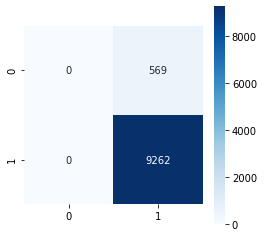

In [117]:
plt.figure(figsize=(4,4)) 
_ = sns.heatmap(confusion_matrix(y_test, y_pred), cmap=plt.cm.Blues, square=True, annot=True, fmt='.4g')

??? Не могу интерпретировать precision

??? По горизонтали истинные по вертикали предсказанны? y_test, y_pred

tn, fp, fn, tp = confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0]).ravel()

0 TN FP  
1 FN TP  
&nbsp;&nbsp;&nbsp;0&nbsp;&nbsp;&nbsp;1  

Если так, то не сходится с лекциями

- precision - можно интерпретировать как долю объектов, названных классификатором положительными и при этом действительно являющимися положительными
    - TP/(TP+FP) 
- recall(полнота) - показывает, какую долю объектов положительного класса из всех объектов положительного класса нашел алгоритм
    - TP/(TP+FN) 
- f1-score  - какой процент положительных/отриц прогнозов оказался верным
    - f1-score = 2*(Recall * Precision) / (Recall + Precision)
- accuracy — доля правильных ответов алгоритма (бесполезна в задачах с неравными классами)

&nbsp;&nbsp;&nbsp;0&nbsp;&nbsp;&nbsp;1  
0 TN FP  
1 FN TP
![](https://hsto.org/web/38e/9d4/892/38e9d4892d9241ea95e1f56e3ef9124c.png)

# Co-co-co-combo (5 баллов)

Добавьте в исходную выборку парные признаки — то есть для каждой пары $(f_i, f_j)$, $i < j$ исходных категориальных признаков добавьте новый категориальный признак $f_{ij}$, значение которого является конкатенацией значений $f_i$ и $f_j$ (желательно через какой-нибудь специальный символ во избежание коллизий). Посчитайте счетчики для этой выборки, найдите качество метода $k$ ближайших соседей с наилучшим $k$ (с фолдингом и без).

In [108]:
df_combo = df.copy()
df_combo.isnull().sum()

ACTION              0
RESOURCE            0
MGR_ID              0
ROLE_ROLLUP_1       0
ROLE_ROLLUP_2       0
ROLE_DEPTNAME       0
ROLE_TITLE          0
ROLE_FAMILY_DESC    0
ROLE_FAMILY         0
ROLE_CODE           0
dtype: int64

In [109]:
def generate_pair_features(df, y_name, separator = '#'):

    columns_df = list(df.columns)
    columns_df.remove(y_name)

    for col_name in columns_df:

        columns_pair = columns_df[:] 
        columns_pair.remove(col_name)
    
        for col_pair_name in columns_pair:
            
            new_col_name = col_name+separator+col_pair_name
            new_col_name_revers = col_pair_name+separator+col_name
            if new_col_name_revers in list(df.columns): #Если столбец с обратной парой уже существует, то пропускаем
                continue
            else:
                df[new_col_name] = df.apply((lambda x: '{}{}{}'.format(x[col_name],separator,x[col_pair_name])), axis=1)
    
    return df

In [110]:
%%time
df_combo = generate_pair_features(df_combo, 'ACTION')

CPU times: user 1min 2s, sys: 145 ms, total: 1min 2s
Wall time: 1min 2s


In [111]:
df_combo.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE,...,ROLE_DEPTNAME#ROLE_TITLE,ROLE_DEPTNAME#ROLE_FAMILY_DESC,ROLE_DEPTNAME#ROLE_FAMILY,ROLE_DEPTNAME#ROLE_CODE,ROLE_TITLE#ROLE_FAMILY_DESC,ROLE_TITLE#ROLE_FAMILY,ROLE_TITLE#ROLE_CODE,ROLE_FAMILY_DESC#ROLE_FAMILY,ROLE_FAMILY_DESC#ROLE_CODE,ROLE_FAMILY#ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908,...,123472#117905,123472#117906,123472#290919,123472#117908,117905#117906,117905#290919,117905#117908,117906#290919,117906#117908,290919#117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539,...,123125#118536,123125#118536,123125#308574,123125#118539,118536#118536,118536#308574,118536#118539,118536#308574,118536#118539,308574#118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880,...,117884#117879,117884#267952,117884#19721,117884#117880,117879#267952,117879#19721,117879#117880,267952#19721,267952#117880,19721#117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322,...,119993#118321,119993#240983,119993#290919,119993#118322,118321#240983,118321#290919,118321#118322,240983#290919,240983#118322,290919#118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325,...,119569#119323,119569#123932,119569#19793,119569#119325,119323#123932,119323#19793,119323#119325,123932#19793,123932#119325,19793#119325


In [112]:
df_combo.columns

Index(['ACTION', 'RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2',
       'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY',
       'ROLE_CODE', 'RESOURCE#MGR_ID', 'RESOURCE#ROLE_ROLLUP_1',
       'RESOURCE#ROLE_ROLLUP_2', 'RESOURCE#ROLE_DEPTNAME',
       'RESOURCE#ROLE_TITLE', 'RESOURCE#ROLE_FAMILY_DESC',
       'RESOURCE#ROLE_FAMILY', 'RESOURCE#ROLE_CODE', 'MGR_ID#ROLE_ROLLUP_1',
       'MGR_ID#ROLE_ROLLUP_2', 'MGR_ID#ROLE_DEPTNAME', 'MGR_ID#ROLE_TITLE',
       'MGR_ID#ROLE_FAMILY_DESC', 'MGR_ID#ROLE_FAMILY', 'MGR_ID#ROLE_CODE',
       'ROLE_ROLLUP_1#ROLE_ROLLUP_2', 'ROLE_ROLLUP_1#ROLE_DEPTNAME',
       'ROLE_ROLLUP_1#ROLE_TITLE', 'ROLE_ROLLUP_1#ROLE_FAMILY_DESC',
       'ROLE_ROLLUP_1#ROLE_FAMILY', 'ROLE_ROLLUP_1#ROLE_CODE',
       'ROLE_ROLLUP_2#ROLE_DEPTNAME', 'ROLE_ROLLUP_2#ROLE_TITLE',
       'ROLE_ROLLUP_2#ROLE_FAMILY_DESC', 'ROLE_ROLLUP_2#ROLE_FAMILY',
       'ROLE_ROLLUP_2#ROLE_CODE', 'ROLE_DEPTNAME#ROLE_TITLE',
       'ROLE_DEPTNAME#ROLE_FAMILY_DESC', 'R

In [113]:
%%time
X_train, X_test, y_train, y_test = CountAndSuccMain(df_combo.copy(), 1, method=1)

CPU times: user 18min 29s, sys: 936 ms, total: 18min 29s
Wall time: 18min 30s


In [114]:
X_train.columns

Index(['MGR_ID#ROLE_CODE_count', 'MGR_ID#ROLE_CODE_flattened',
       'MGR_ID#ROLE_CODE_successes', 'MGR_ID#ROLE_DEPTNAME_count',
       'MGR_ID#ROLE_DEPTNAME_flattened', 'MGR_ID#ROLE_DEPTNAME_successes',
       'MGR_ID#ROLE_FAMILY_DESC_count', 'MGR_ID#ROLE_FAMILY_DESC_flattened',
       'MGR_ID#ROLE_FAMILY_DESC_successes', 'MGR_ID#ROLE_FAMILY_count',
       ...
       'ROLE_TITLE#ROLE_CODE_successes', 'ROLE_TITLE#ROLE_FAMILY_DESC_count',
       'ROLE_TITLE#ROLE_FAMILY_DESC_flattened',
       'ROLE_TITLE#ROLE_FAMILY_DESC_successes', 'ROLE_TITLE#ROLE_FAMILY_count',
       'ROLE_TITLE#ROLE_FAMILY_flattened', 'ROLE_TITLE#ROLE_FAMILY_successes',
       'ROLE_TITLE_count', 'ROLE_TITLE_flattened', 'ROLE_TITLE_successes'],
      dtype='object', length=135)

In [115]:
X_test.isnull().sum()

MGR_ID#ROLE_CODE_count              1060
MGR_ID#ROLE_CODE_flattened          1060
MGR_ID#ROLE_CODE_successes          1060
MGR_ID#ROLE_DEPTNAME_count           606
MGR_ID#ROLE_DEPTNAME_flattened       606
                                    ... 
ROLE_TITLE#ROLE_FAMILY_flattened      23
ROLE_TITLE#ROLE_FAMILY_successes      23
ROLE_TITLE_count                      23
ROLE_TITLE_flattened                  23
ROLE_TITLE_successes                  23
Length: 135, dtype: int64

In [116]:
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
pass

In [117]:
params = {
    "n_neighbors": np.arange(2, 10, 2), 
    "p": [1,4]
}

search = GridSearchCV(KNeighborsClassifier(), params, n_jobs=2, 
                      cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), verbose=2)
%time search.fit(pd.concat([X_train,X_test]), pd.concat([y_train,y_test]))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  9.3min
[Parallel(n_jobs=2)]: Done  40 out of  40 | elapsed: 10.8min finished


CPU times: user 1.43 s, sys: 108 ms, total: 1.54 s
Wall time: 10min 51s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=2,
             param_grid={'n_neighbors': array([2, 4, 6, 8]), 'p': [1, 4]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [118]:
print("BEST: score={}, params={}".format(search.best_score_, search.best_params_))

BEST: score=0.9459550750736432, params={'n_neighbors': 6, 'p': 1}


In [119]:
clf = KNeighborsClassifier(n_neighbors=6, p=1)
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=6, p=1,
                     weights='uniform')

In [120]:
y_pred = clf.predict(X_test).astype('int')

- постройте отчет классификации (classification_report)
- постройте confusion matrix и нарисуйте heatmap

Оцените на сколько улучшилось качество. Не похоже ли это на переобусение?

Внимание! Обучение на этом этапе может быть долгим. На i5 16GB кроссвалидация на 5 фолдах заняла 30 минут!

In [121]:
#отчет классификации
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.36      0.44       569
           1       0.96      0.98      0.97      9262

    accuracy                           0.95      9831
   macro avg       0.76      0.67      0.71      9831
weighted avg       0.94      0.95      0.94      9831



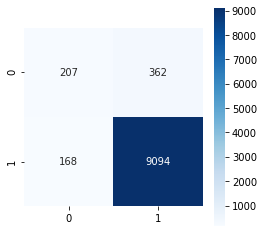

In [122]:
plt.figure(figsize=(4,4)) 
_ = sns.heatmap(confusion_matrix(y_test, y_pred), cmap=plt.cm.Blues, square=True, annot=True, fmt='.4g')